#Load the small-faces dataset

In [1]:
from IPython.display import clear_output
!wget https://ml.gan4x4.ru/msu/dep-1.9/datasets/small_face_dataset.zip
!unzip small_face_dataset.zip


--2023-12-11 20:16:21--  https://ml.gan4x4.ru/msu/dep-1.9/datasets/small_face_dataset.zip
Resolving ml.gan4x4.ru (ml.gan4x4.ru)... 212.24.105.216
Connecting to ml.gan4x4.ru (ml.gan4x4.ru)|212.24.105.216|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3816278 (3.6M) [application/zip]
Saving to: ‘small_face_dataset.zip’

small_face_dataset. 100%[===================>]   3.64M  1.25MB/s    in 2.9s    

2023-12-11 20:16:25 (1.25 MB/s) - ‘small_face_dataset.zip’ saved [3816278/3816278]

Archive:  small_face_dataset.zip
   creating: faces/
   creating: faces/testing/
   creating: faces/testing/s5/
  inflating: faces/testing/s5/1.pgm  
  inflating: faces/testing/s5/10.pgm  
  inflating: faces/testing/s5/2.pgm  
  inflating: faces/testing/s5/3.pgm  
  inflating: faces/testing/s5/4.pgm  
  inflating: faces/testing/s5/5.pgm  
  inflating: faces/testing/s5/6.pgm  
  inflating: faces/testing/s5/7.pgm  
  inflating: faces/testing/s5/8.pgm  
  inflating: faces/testing/s5/9.p

In [2]:
!pip install lightning

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 10.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 806.1/806.1 kB 14.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 776.9/776.9 kB 19.3 MB/s eta 0:00:00


In [3]:
!pip install pytorch-metric-learning

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 2.3 MB/s eta 0:00:00


If dataset in cell above too easy for, you can try http://vis-www.cs.umass.edu/lfw/lfw.tgz



## Create dataset & dataloader classes

In [1]:
import torch
from torch.utils.data import Dataset
from glob import glob
from itertools import product
from PIL import Image

class PairDataset(Dataset):

  def __init__(self, dir=None, transform=None):
    self.dir = dir
    self.transform = transform
    self.data = self.load_data()
    self.labels = self.load_labels()
    self.cache = {}

  def load_data(self):
    files = glob(f"{self.dir}/*/*")
    return list(filter(lambda f: f[0] != f[1], product(files, files)))

  def in_same_dir(self, f0, f1):
    return 1 if '/'.join(f0.split('/')[:-1]) == '/'.join(f1.split('/')[:-1]) else 0

  def load_labels(self):
    return [self.in_same_dir(f0, f1) for (f0, f1) in self.data]

  def __len__(self):
    return len(self.data)

  def load_img(self, path):
    if path in self.cache:
      img = self.cache[path]
    else:
      img = Image.open(path)
      self.cache[path] = img

    if self.transform:
      img = self.transform(img)

    return img

  def __getitem__(self, index):
    img0_path, img1_path = self.data[index]
    label = self.labels[index]

    img0 = self.load_img(img0_path)
    img1 = self.load_img(img1_path)

    return img0, img1, label


In [31]:
from torchvision import transforms, utils
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from pytorch_metric_learning.samplers import MPerClassSampler

transform = transforms.Compose([
    transforms.Resize((92, 92)),
    transforms.Grayscale(),
    transforms.ToTensor()
    # TODO: нормализация
])

train_ds = ImageFolder('faces/training', transform)
train_dl = DataLoader(train_ds, batch_size=8, shuffle=True)

test_pair_ds = PairDataset('faces/testing', transform)
test_pair_dl = DataLoader(test_pair_ds, batch_size=8)

mpc_sampler = MPerClassSampler(train_ds.targets, m=3, length_before_new_iter=10000)
train_sampler_dl = DataLoader(train_ds, batch_size=8, sampler=mpc_sampler)



0 0


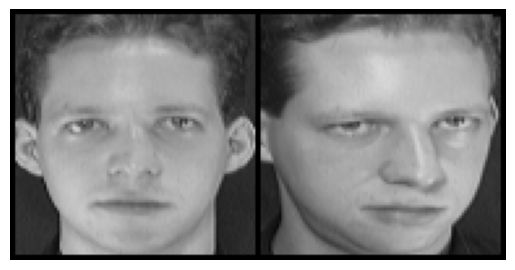

In [3]:
import matplotlib.pyplot as plt

img0, label0 = train_ds[0]
img1, label1 = train_ds[1]

print(label0, label1)

grid = utils.make_grid([img0, img1])

plt.axis("off")
plt.rcParams["figure.figsize"] = (20,15)
plt.imshow(grid.permute(1,2,0).numpy())
plt.show()

#Define the model for embedding extraction

In [4]:
# Put your code here
from torchvision.models import resnet18
from torch import nn

def get_model():
  model = resnet18(pretrained=True)
  for param in model.parameters():
    param.requires_grad = False
  model.conv1 = nn.Conv2d(1, 64, (5, 5), stride=(2, 2), padding=(2, 2), bias=False)
  model.fc = nn.Linear(512, 64, bias=True)
  return model


In [5]:
model = get_model()

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


#Train the model

In [6]:
# Put your code here
import lightning as L
from torch import optim
from pytorch_metric_learning.miners import TripletMarginMiner
from pytorch_metric_learning.losses import TripletMarginLoss

class TripletLossModel(L.LightningModule):

  def __init__(self, model, margin=0.2):
    super().__init__()
    self.model = model
    self.miner = TripletMarginMiner(margin, type_of_triplets="all")
    self.criterion = TripletMarginLoss(margin)

  # def forward(self, x):
  #   return super().forward(x)

  def configure_optimizers(self):
    optimizer = optim.AdamW(self.parameters(), lr=self.lr)
    return optimizer

  def training_step(self, batch, batch_idx):
    x, y = batch
    embeddings = self.model(x)
    triplets = self.miner(embeddings, y)
    if batch_idx % 100 == 0:
      print(batch_idx, embeddings.shape, triplets[0].shape)
    loss = self.criterion(embeddings, y, triplets)
    return loss

  # def validation_step(self, batch, batch_idx):
  #   pass



In [7]:
from torch import tensor

m = 0.5
t = tensor([[0.1], [0.2], [0.3]])

tmm = TripletMarginMiner(m, type_of_triplets="all")
tr = tmm(t, tensor([1, 1, 2]))
print(tr)

# нормализует векторы!
tml = TripletMarginLoss(m)
tml(t, tensor([1, 1, 2]), tr)

In [8]:
triplet_loss_model = TripletLossModel(model)
triplet_loss_model.lr = 1e-5
trainer = L.Trainer(max_epochs=10)
trainer.fit(model=triplet_loss_model, train_dataloaders=train_sampler_dl)

INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name      | Type               | Params
-------------------------------------------------
0 | model     | ResNet             | 11.2 M
1 | miner     | TripletMarginMiner | 0     
2 | criterion | TripletMarginLoss  | 0     
-------------------------------------------------
34.4 K    Trainable params
11.2 M    Non-trainable params
11.2 M    Total params
44.80

Training: |          | 0/? [00:00<?, ?it/s]

0 torch.Size([8, 64]) torch.Size([63])
100 torch.Size([8, 64]) torch.Size([53])
200 torch.Size([8, 64]) torch.Size([65])
300 torch.Size([8, 64]) torch.Size([59])
400 torch.Size([8, 64]) torch.Size([32])
500 torch.Size([8, 64]) torch.Size([54])
600 torch.Size([8, 64]) torch.Size([65])
700 torch.Size([8, 64]) torch.Size([31])
800 torch.Size([8, 64]) torch.Size([28])
900 torch.Size([8, 64]) torch.Size([9])
1000 torch.Size([8, 64]) torch.Size([22])
1100 torch.Size([8, 64]) torch.Size([40])
1200 torch.Size([8, 64]) torch.Size([37])
0 torch.Size([8, 64]) torch.Size([14])
100 torch.Size([8, 64]) torch.Size([14])
200 torch.Size([8, 64]) torch.Size([12])
300 torch.Size([8, 64]) torch.Size([35])
400 torch.Size([8, 64]) torch.Size([10])
500 torch.Size([8, 64]) torch.Size([16])
600 torch.Size([8, 64]) torch.Size([7])
700 torch.Size([8, 64]) torch.Size([41])
800 torch.Size([8, 64]) torch.Size([22])
900 torch.Size([8, 64]) torch.Size([2])
1000 torch.Size([8, 64]) torch.Size([34])
1100 torch.Size([8,

INFO: `Trainer.fit` stopped: `max_epochs=10` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.


# Calculate metrics

In [13]:
# Put your code here
# Я про это забыл и искал ошибку час!
model.eval()
#

f = []
cos = nn.CosineSimilarity()
for x0, x1, label in test_pair_dl:
  emb0 = model(x0)
  emb1 = model(x1)
  f.extend(cos(emb0, emb1).tolist())


In [14]:
(x0, y0) = train_ds[0]
(x1, y1) = train_ds[10]
print(cos(model(x0.unsqueeze(0)), model(x1.unsqueeze(0))))
print(y0 == y1)

tensor([0.0633], grad_fn=<SumBackward1>)
False


In [27]:
import numpy as np

def calc_metrics(f, labels, threshold):
  f = np.array(f)
  labels = np.array(labels)
  n_targets = (labels == 1).sum()
  n_imposters = (labels == 0).sum()
  frr = (f[labels == 1] < threshold).sum() / n_targets
  far = (f[labels == 0] > threshold).sum() / n_imposters
  return far, frr

far, frr = calc_metrics(f, test_pair_ds.labels, 0.175)
print(f'FAR={far}')
print(f'FRR={frr}')


FAR=0.11
FRR=0.1111111111111111


# Display the results

You can use faiss: https://github.com/facebookresearch/faiss

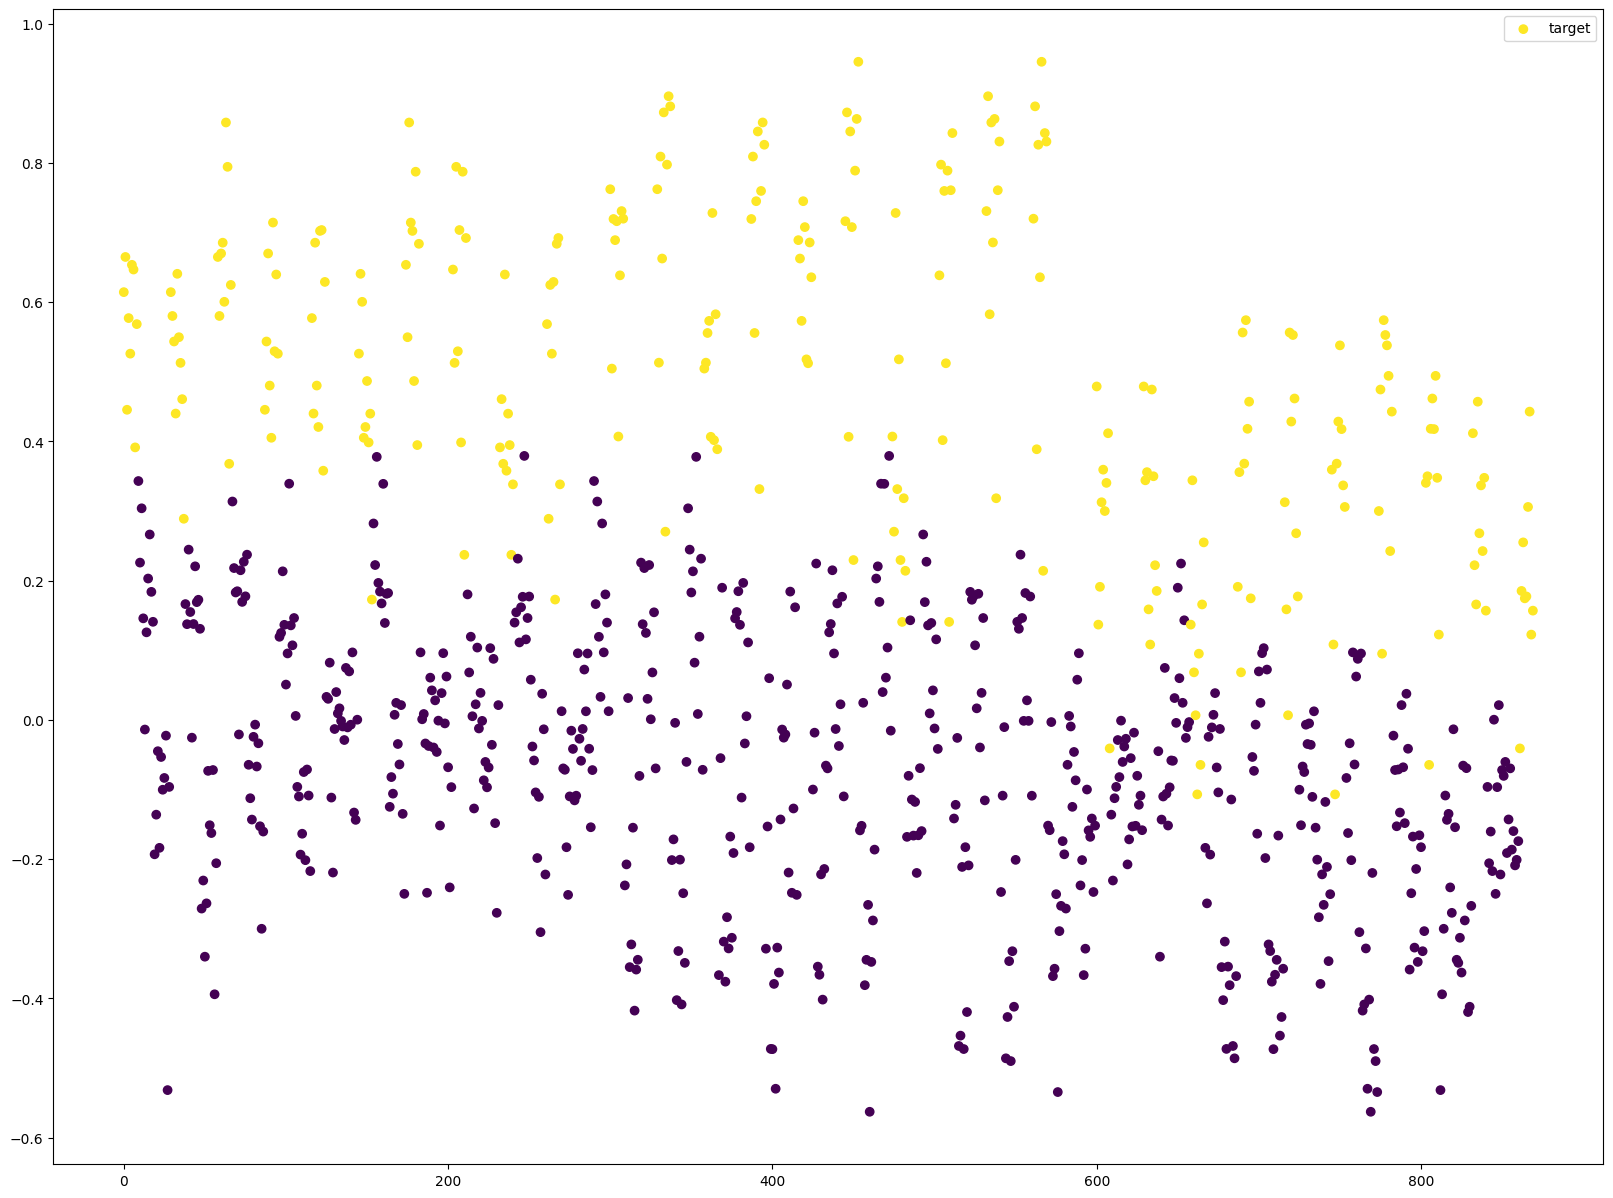

In [28]:
# Put your code here
plt.scatter([i for i in range(len(f))], f, c=test_pair_ds.labels)
plt.legend(['target'])
plt.show()

In [35]:
# Попробуем с ArcFace

from pytorch_metric_learning.losses import ArcFaceLoss

class ArcFaceModel(L.LightningModule):

  def __init__(self, model, margin=0.2):
    super().__init__()
    self.model = model
    self.criterion = ArcFaceLoss(37, 64)

  # def forward(self, x):
  #   return super().forward(x)

  def configure_optimizers(self):
    optimizer = optim.AdamW(self.parameters(), lr=self.lr)
    return optimizer

  def training_step(self, batch, batch_idx):
    x, y = batch
    embeddings = self.model(x)
    if batch_idx % 10 == 0:
      print(batch_idx, embeddings.shape)
    loss = self.criterion(embeddings, y)
    return loss

  # def validation_step(self, batch, batch_idx):
  #   pass

In [30]:
len(train_ds.classes)

37

In [36]:
model = get_model()
arc_face_model = ArcFaceModel(model)
arc_face_model.lr = 1e-5
trainer = L.Trainer(max_epochs=20)
trainer.fit(model=arc_face_model, train_dataloaders=train_dl)


INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name      | Type        | Params
------------------------------------------
0 | model     | ResNet      | 11.2 M
1 | criterion | ArcFaceLoss | 2.4 K 
------------------------------------------
36.8 K    Trainable params
11.2 M    Non-trainable params
11.2 M    Total params
44.816    Total estimated model params size (MB)
INFO:lightning.pytorch.callbacks.mo

Training: |          | 0/? [00:00<?, ?it/s]

0 torch.Size([8, 64])
10 torch.Size([8, 64])
20 torch.Size([8, 64])
30 torch.Size([8, 64])
40 torch.Size([8, 64])
0 torch.Size([8, 64])
10 torch.Size([8, 64])
20 torch.Size([8, 64])
30 torch.Size([8, 64])
40 torch.Size([8, 64])
0 torch.Size([8, 64])
10 torch.Size([8, 64])
20 torch.Size([8, 64])
30 torch.Size([8, 64])
40 torch.Size([8, 64])
0 torch.Size([8, 64])
10 torch.Size([8, 64])
20 torch.Size([8, 64])
30 torch.Size([8, 64])
40 torch.Size([8, 64])
0 torch.Size([8, 64])
10 torch.Size([8, 64])
20 torch.Size([8, 64])
30 torch.Size([8, 64])
40 torch.Size([8, 64])
0 torch.Size([8, 64])
10 torch.Size([8, 64])
20 torch.Size([8, 64])
30 torch.Size([8, 64])
40 torch.Size([8, 64])
0 torch.Size([8, 64])
10 torch.Size([8, 64])
20 torch.Size([8, 64])
30 torch.Size([8, 64])
40 torch.Size([8, 64])
0 torch.Size([8, 64])
10 torch.Size([8, 64])
20 torch.Size([8, 64])
30 torch.Size([8, 64])
40 torch.Size([8, 64])
0 torch.Size([8, 64])
10 torch.Size([8, 64])
20 torch.Size([8, 64])
30 torch.Size([8, 64

INFO: `Trainer.fit` stopped: `max_epochs=20` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=20` reached.


In [37]:
model.eval()

f = []
cos = nn.CosineSimilarity()
for x0, x1, label in test_pair_dl:
  emb0 = model(x0)
  emb1 = model(x1)
  f.extend(cos(emb0, emb1).tolist())

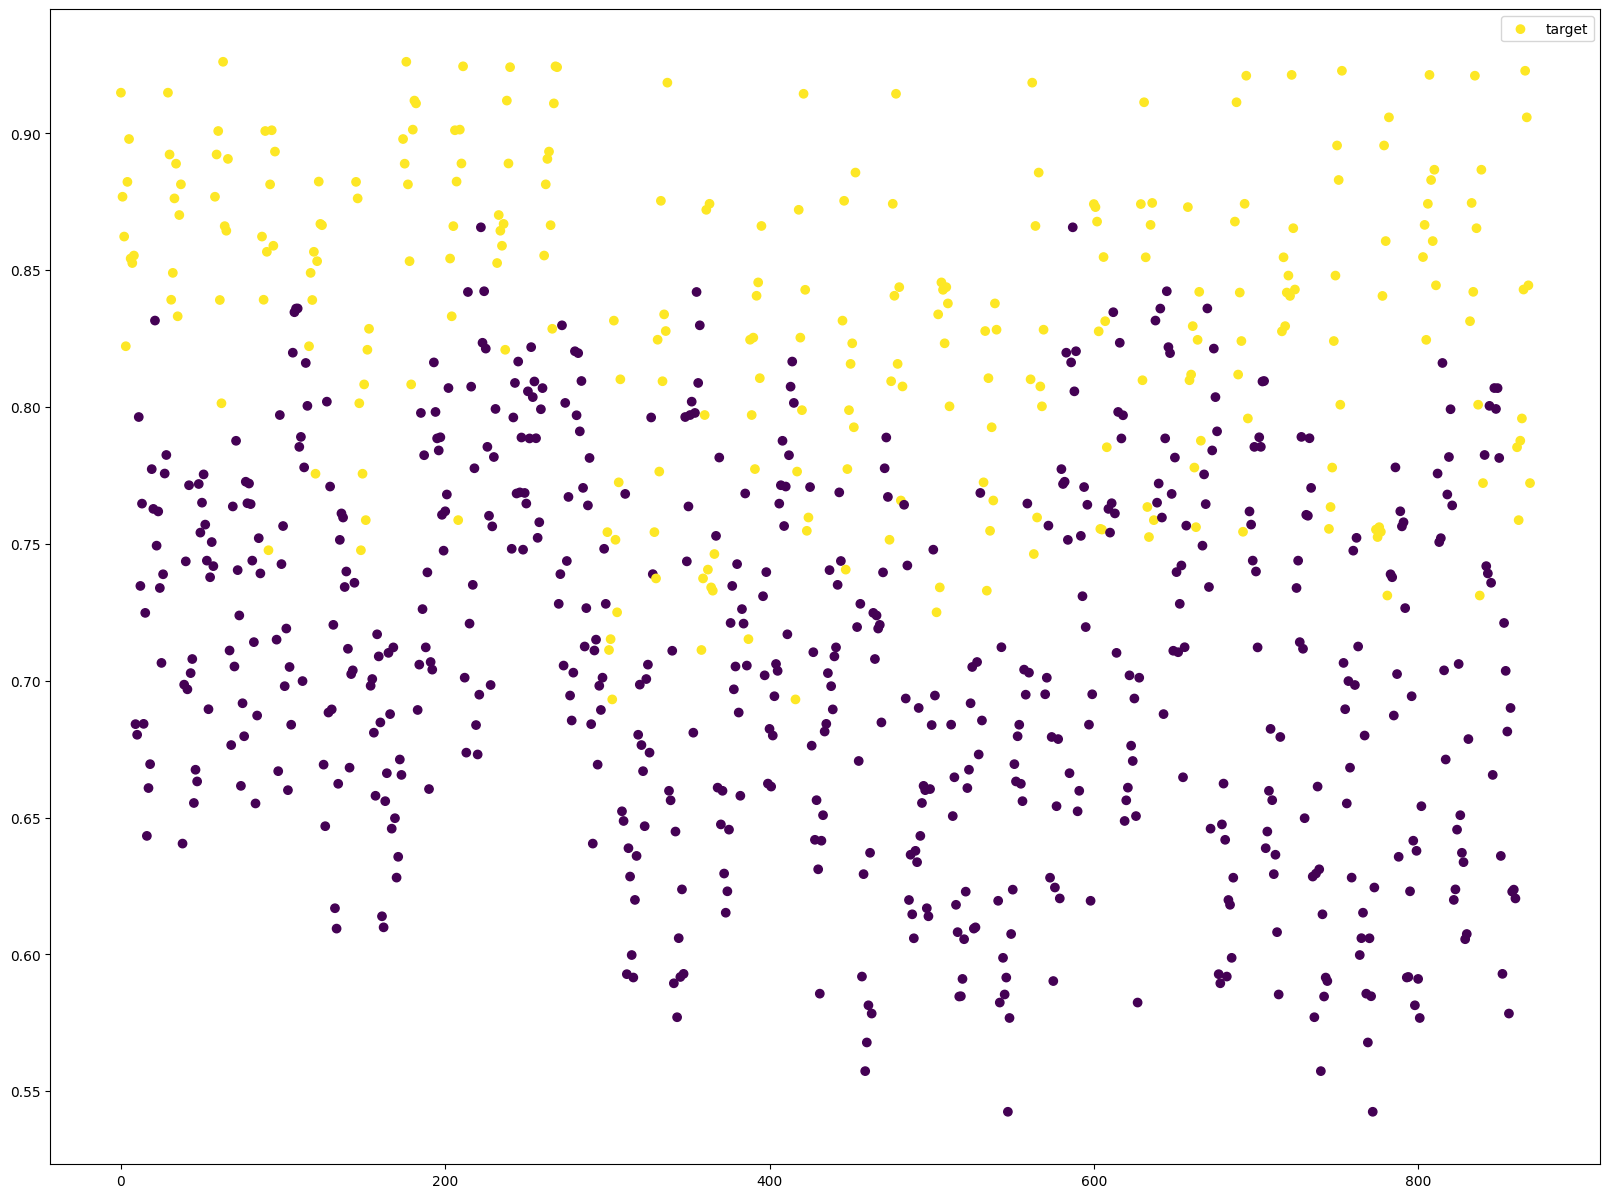

In [38]:
plt.scatter([i for i in range(len(f))], f, c=test_pair_ds.labels)
plt.legend(['target'])
plt.show()

In [52]:
far, frr = calc_metrics(f, test_pair_ds.labels, 0.775)
print(f'FAR={far}')
print(f'FRR={frr}')

FAR=0.19
FRR=0.1925925925925926


#Place for conclusion

TripletMarginLoss дал значения метрики ERR примерно 11%, а ArcFaceLoss примерно 19%, что на порядок хуже. Также я хотел попробовать TripletProbabilisticLoss, которая упоминалась в статье, но не успел